### This script shows the **RICE PANICLE IMAGE PROCESSING PIPELINE**.

- **PIPELINE**: Binarizing -> Thinning -> Clustering -> Evaluation( All | Main Axis | High Order ).
- We go over this pipeline 3 times to evaluate the accuracy on **All junctions**, **Main axis junctions** and **high order junctions**.
- **Naming convention**:
  - **all junctions**: _1
  - **main axis junctions**: _2
  - **high order junctions**: _3

In [1]:
# Import necessary module
import sys
sys.path.append('../../src')

import cv2
import numpy as np
import matplotlib.pyplot as plt
from image_processor.RicePanicle import RicePanicle
from utils.ricepr_manipulate import resize_junction
from utils.evaluation_image_generating import generate_y_true, generate_skeleton_main_axis
from pipeline import _merge_pred

In [2]:
# Some paths we need for every time we run a pipeline
binary_path = "../../crack_segmentation/transfer-learning-results/run_2/U2CRACKNET/13_2_1_1_1_DSC01478.png"
binary_img = cv2.imread(binary_path, cv2.IMREAD_GRAYSCALE)

# We have to convert the original junction's coordinates into the size of (512, 512) for consistency
ricepr_path = "../../data/original_ricepr/O. sativa/13_2_1_1_1_DSC01478.ricepr"
junction_resized = resize_junction(ricepr_path)

raw_img_512 = plt.imread("../../images/raw_images_512/O. sativa/13_2_1_1_1_DSC01478.jpg")

# **PIPELINE #1**

### *THINNING*

In [3]:
skeleton_img_1 = RicePanicle.Thinning.zhang_suen(binary_img)

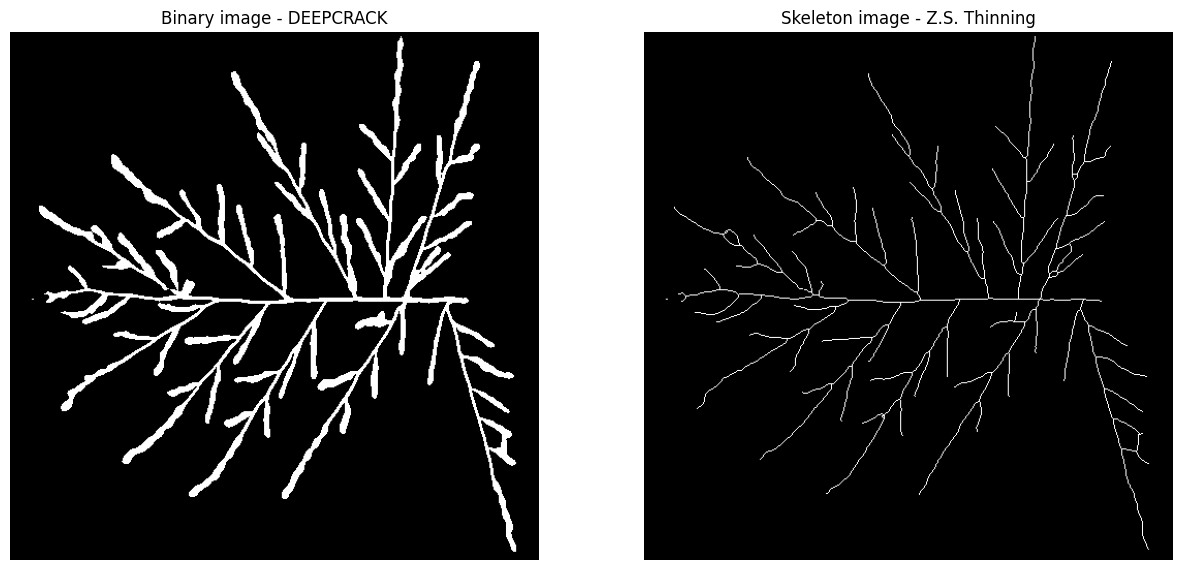

In [4]:
# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

ax1.imshow(binary_img, cmap='gray')
ax1.axis('off')
ax1.set_title("Binary image - DEEPCRACK")

ax2.imshow(skeleton_img_1, cmap='gray')
ax2.axis('off')
ax2.set_title("Skeleton image - Z.S. Thinning")

plt.show()

### *CLUSTERING*

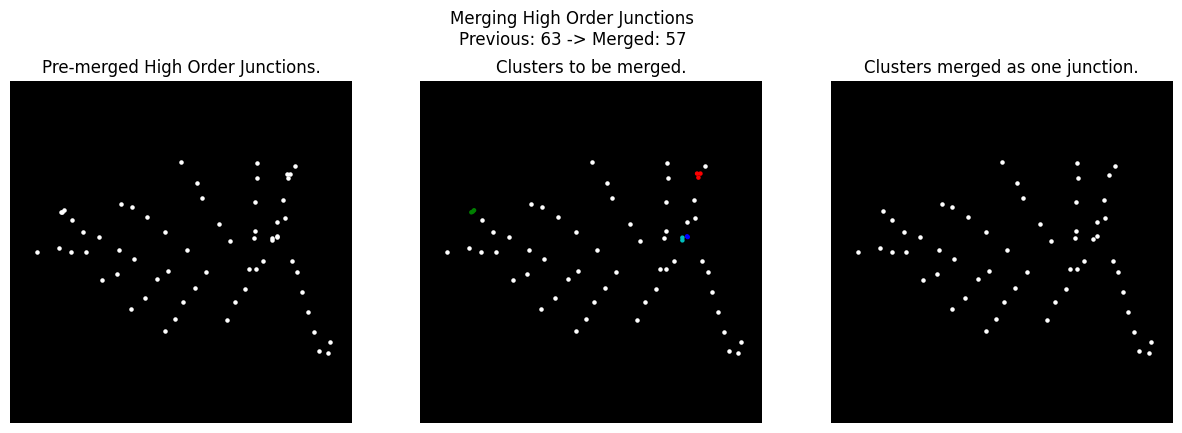

We have predicted 68 junctions of all levels


In [5]:
# CLUSTERING requires a skeleton image, returns junction image and y_pred. 
# 1. y_pred_1
junction_img_1, y_pred_1 = RicePanicle.Clustering.crossing_number(skeleton_img_1, return_pred_=True)
# 2. y_pred_2
skeleton_img_2 = generate_skeleton_main_axis(skeleton_img_1, ricepr_path)
junction_img_2, y_pred_2 = RicePanicle.Clustering.crossing_number(skeleton_img_2, return_pred_=True)
# 3. y_pred_3 = (y_pred_1 - y_pred_2)
skeleton_img_3 = skeleton_img_1 - skeleton_img_2
y_pred_3 = y_pred_1 - y_pred_2
# 4. y_pred_3_merged
junction_img_3, y_pred_3_merged = _merge_pred(y_pred_3, skeleton_img_3, True)
# 5. y_pred_1 = y_pred_2 + y_pred_3_merged
y_pred_1 = y_pred_2 + y_pred_3_merged
    
n_pred_1 = len(y_pred_1[y_pred_1 > 0])
print(f"We have predicted {n_pred_1} junctions of all levels")

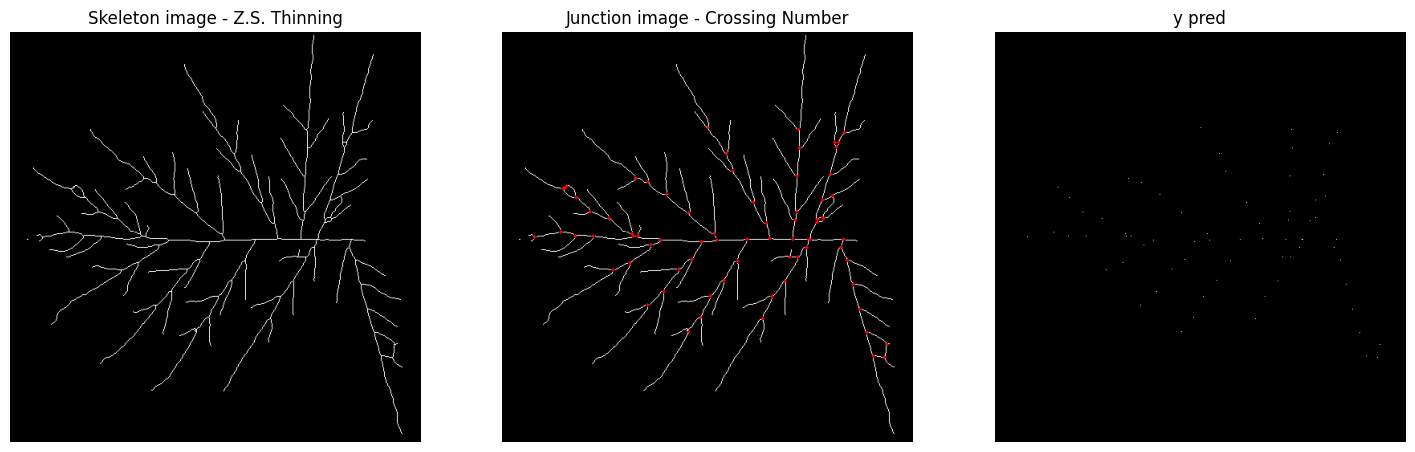

In [6]:
# Visualization
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

ax1.imshow(skeleton_img_1, cmap='gray')
ax1.axis('off')
ax1.set_title("Skeleton image - Z.S. Thinning")

ax2.imshow(junction_img_1, cmap='gray')
ax2.axis('off')
ax2.set_title("Junction image - Crossing Number")

ax3.imshow(y_pred_1, cmap='gray')
ax3.axis('off')
ax3.set_title("y pred")

plt.show()

### *EVALUATION*

In [7]:
# EVALUATION requires y_true ---(needs generating)---> true junction and y_pred ----(already have)----> predicted junction
y_true_1 = generate_y_true(junction_resized)
n_true_1 = len(y_true_1[y_true_1 > 0])
print(f"There are {n_true_1} TRUE junctions of all levels.")

There are 63 TRUE junctions of all levels.


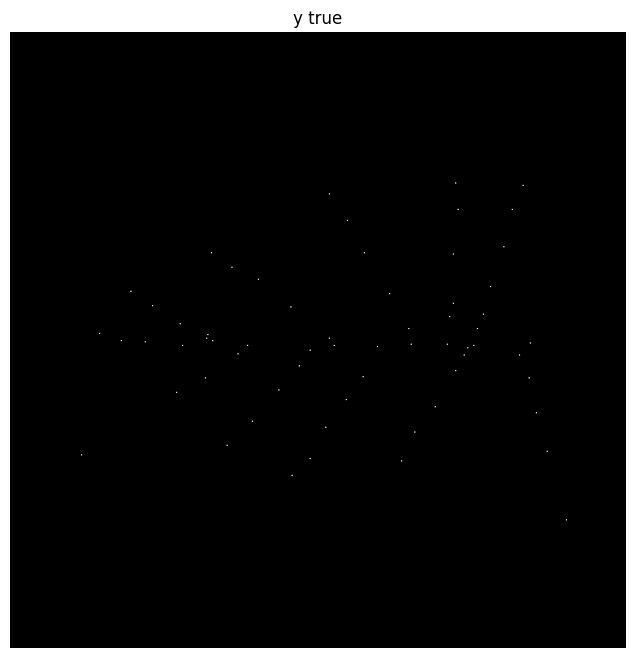

In [8]:
# Visualization
plt.figure(figsize=(8, 8))
plt.imshow(y_true_1, cmap='gray')
plt.axis('off')
plt.title("y true")
plt.show()

In [9]:
f1, pr, rc = RicePanicle.Evaluation.f1_score(y_true_1, y_pred_1, _return_metrics=True)
print(f"f1: {f1}, precision: {pr}, recall: {rc}")

f1: 0.6717557251908397, precision: 0.6470588235294118, recall: 0.6984126984126984


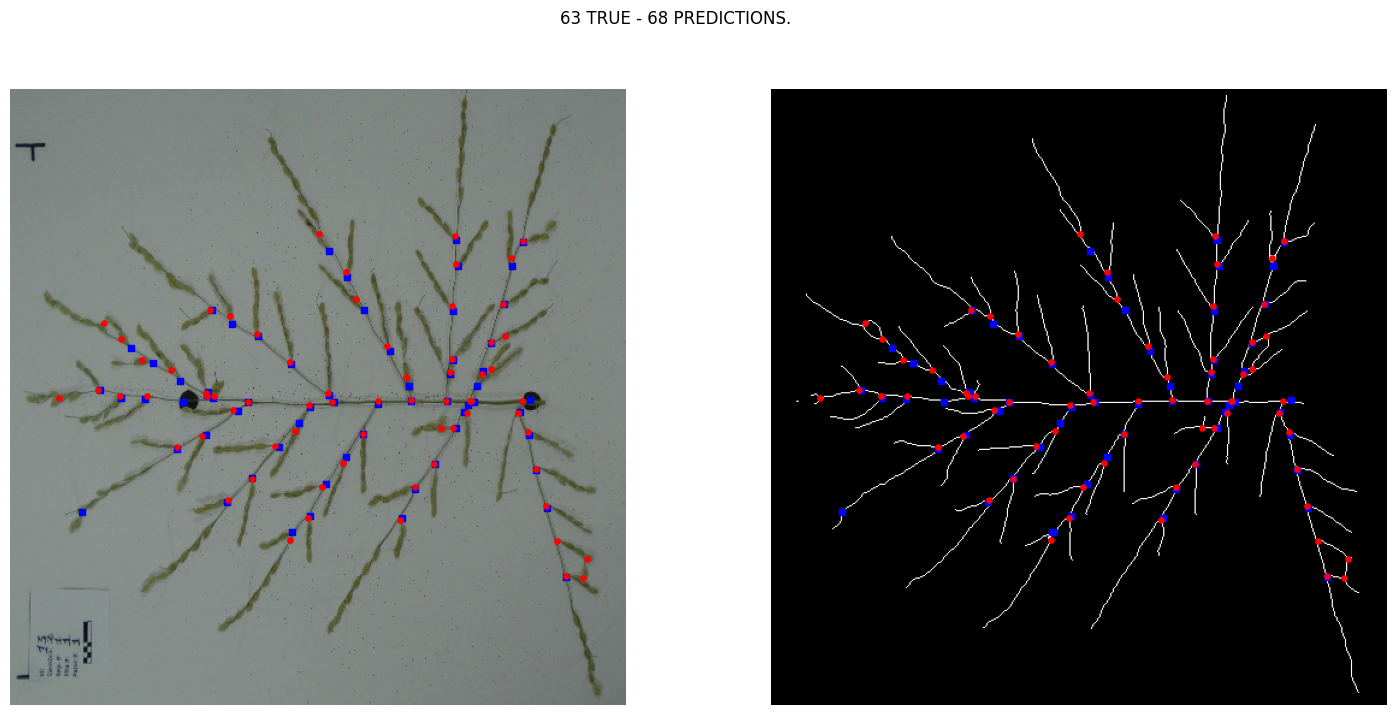

In [10]:
# Visualization
white_px_true_1 = np.argwhere(y_true_1 > 0)
white_px_pred_1 = np.argwhere(y_pred_1 > 0)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

ax1.imshow(raw_img_512, cmap='gray')
ax1.scatter(white_px_true_1[:, 1], white_px_true_1[:, 0], s=14, c='b', marker='s')
ax1.scatter(white_px_pred_1[:, 1], white_px_pred_1[:, 0], s=14, c='r', marker='o')
ax1.axis('off')

ax2.imshow(skeleton_img_1, cmap='gray')
ax2.scatter(white_px_true_1[:, 1], white_px_true_1[:, 0], s=14, c='b', marker='s')
ax2.scatter(white_px_pred_1[:, 1], white_px_pred_1[:, 0], s=14, c='r', marker='o')
ax2.axis('off')

plt.suptitle(f"{n_true_1} TRUE - {n_pred_1} PREDICTIONS.")
plt.show()

# **PIPELINE #2**

### *THINNING*

In [11]:
# Generate y_true for main axis
y_true_2 = generate_y_true(junction_resized, main_axis=True)
n_true_2 = len(y_true_2[y_true_2 > 0])
print(f"There are {n_true_2} TRUE main axis junctions.")

# Generate skeleton for main axis -> Generate y_pred for main axis
skeleton_img_2 = generate_skeleton_main_axis(skeleton_img_1, ricepr_path)


There are 11 TRUE main axis junctions.


### *CLUSTERING*

In [12]:
# Clustering to create y_pred
junction_img_2, y_pred_2 = RicePanicle.Clustering.crossing_number(skeleton_img_2, return_pred_=True)
n_pred_2 = len(y_pred_2[y_pred_2 > 0])
print(f"We have predicted {n_pred_2} main axis junctions")

We have predicted 11 main axis junctions


### *EVALUATION*

In [13]:
# Evaluating
f1, pr, rc = RicePanicle.Evaluation.f1_score(y_true_2, y_pred_2, _return_metrics=True)
print(f"f1: {f1}, precision: {pr}, recall: {rc}")

f1: 0.8181818181818182, precision: 0.8181818181818182, recall: 0.8181818181818182


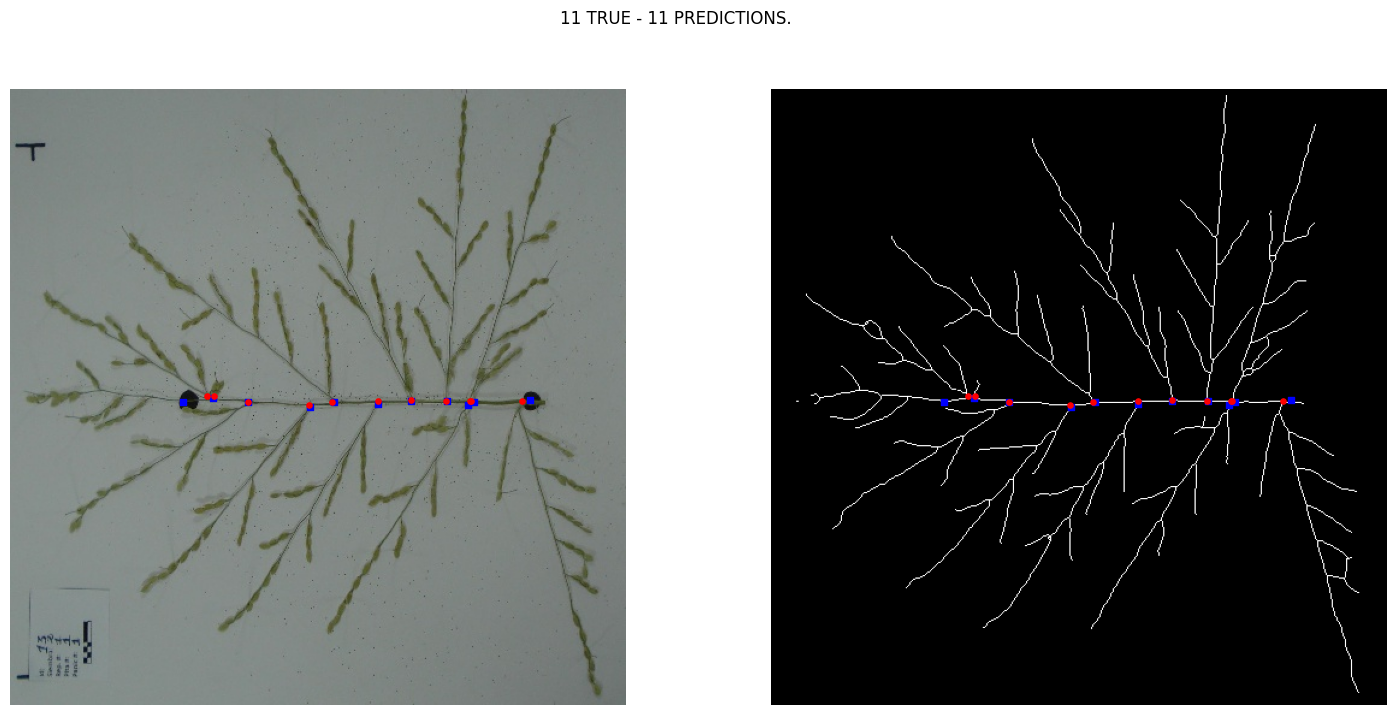

In [14]:
# Visualization
white_px_true_2 = np.argwhere(y_true_2 > 0)
white_px_pred_2 = np.argwhere(y_pred_2 > 0)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

ax1.imshow(raw_img_512, cmap='gray')
ax1.scatter(white_px_true_2[:, 1], white_px_true_2[:, 0], s=14, c='b', marker='s')
ax1.scatter(white_px_pred_2[:, 1], white_px_pred_2[:, 0], s=14, c='r', marker='o')
ax1.axis('off')

ax2.imshow(skeleton_img_1, cmap='gray')
ax2.scatter(white_px_true_2[:, 1], white_px_true_2[:, 0], s=14, c='b', marker='s')
ax2.scatter(white_px_pred_2[:, 1], white_px_pred_2[:, 0], s=14, c='r', marker='o')
ax2.axis('off')

plt.suptitle(f"{n_true_2} TRUE - {n_pred_2} PREDICTIONS.")
plt.show()

# **PIPELINE #3**

### *THINNING*

In [15]:
# Generate y_true for main axis
y_true_3 = y_true_1 - y_true_2
n_true_3 = len(y_true_3[y_true_3 > 0])
print(f"There are {n_true_3} TRUE high order junctions.")

# Generate skeleton for main axis -> Generate y_pred for main axis
skeleton_img_3 = skeleton_img_1 - skeleton_img_2

There are 52 TRUE high order junctions.


### *CLUSTERING*

In [16]:
# Clustering to create y_pred
junction_img_3, y_pred_3 = RicePanicle.Clustering.crossing_number(skeleton_img_3, return_pred_=True)
y_pred_3 = y_pred_1 - y_pred_2
n_pred_3 = len(y_pred_3[y_pred_3 > 0])
print(f"We have predicted {n_pred_3} high order junctions")

We have predicted 57 high order junctions


### *EVALUATION*

In [17]:
# Evaluating
f1, pr, rc = RicePanicle.Evaluation.f1_score(y_true_3, y_pred_3, _return_metrics=True)
print(f"f1: {f1}, precision: {pr}, recall: {rc}")

f1: 0.6238532110091742, precision: 0.5964912280701754, recall: 0.6538461538461539


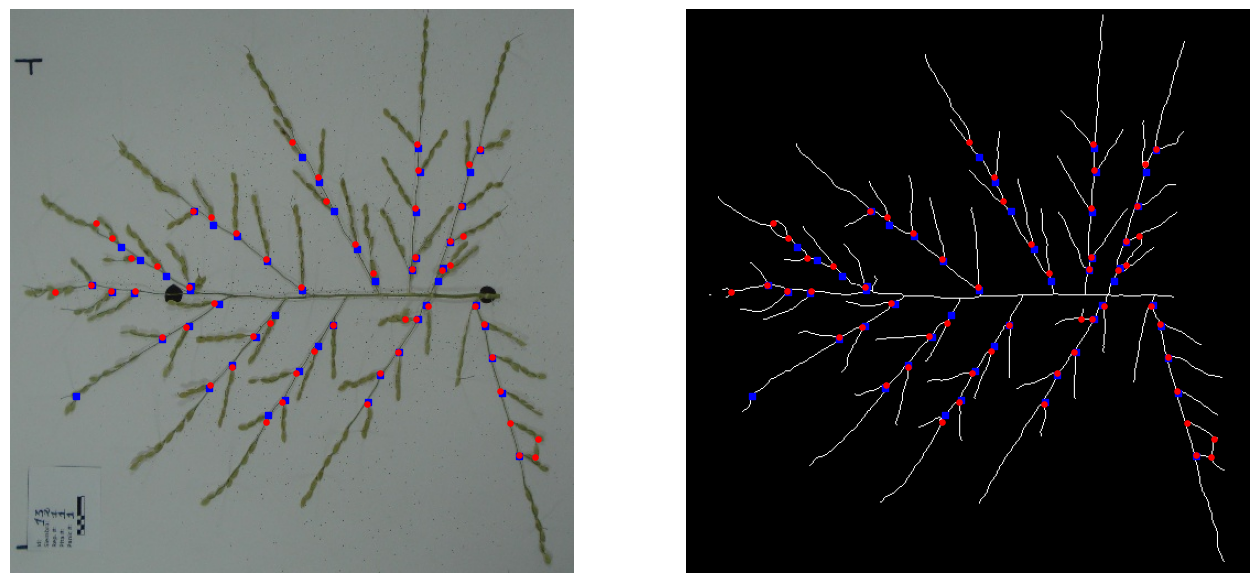

In [18]:
# Visualization
white_px_true_3 = np.argwhere(y_true_3 > 0)
white_px_pred_3 = np.argwhere(y_pred_3 > 0)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

ax1.imshow(raw_img_512, cmap='gray')
ax1.scatter(white_px_true_3[:, 1], white_px_true_3[:, 0], s=14, c='b', marker='s')
ax1.scatter(white_px_pred_3[:, 1], white_px_pred_3[:, 0], s=14, c='r', marker='o')
ax1.axis('off')

ax2.imshow(skeleton_img_1, cmap='gray')
ax2.scatter(white_px_true_3[:, 1], white_px_true_3[:, 0], s=14, c='b', marker='s')
ax2.scatter(white_px_pred_3[:, 1], white_px_pred_3[:, 0], s=14, c='r', marker='o')
ax2.axis('off')

plt.show()